# Cell 1: Importing Libraries and Defining Constants


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, EfficientNetB0
import matplotlib.pyplot as plt
import os
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 40

# Cell 2: Loading and Partitioning Dataset



Found 2152 files belonging to 3 classes.
Number of classes: 3
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Number of training samples: 54
Number of validation samples: 6
Number of test samples: 8
Image size: 256
Batch size: 32
Batch shape: (32, 256, 256, 3)
Labels: [0 1 1 0 1 1 1 0 0 0 2 0 1 2 0 0 0 1 0 0 2 0 1 0 1 1 0 0 1 2 0 0]


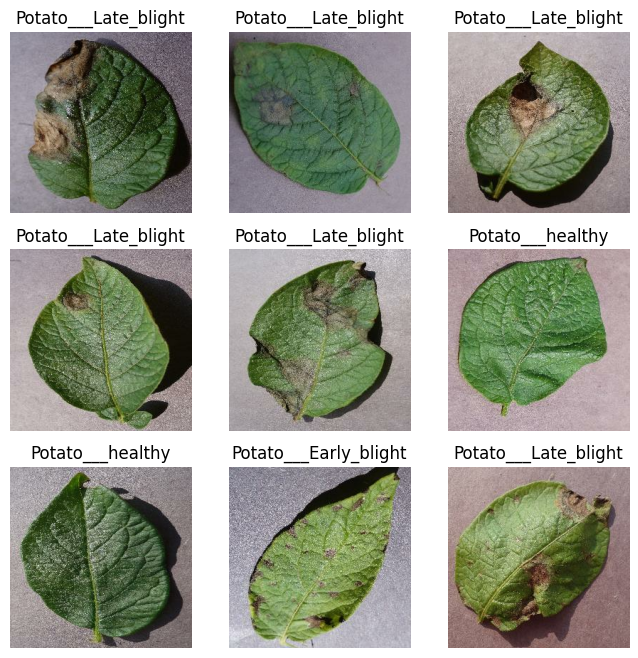

In [2]:
# dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "P",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
# Partitioning dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
# Dataset Info
print("Number of classes:", len(class_names))
print(class_names)
print("Number of training samples:", len(train_ds))
print("Number of validation samples:", len(val_ds))
print("Number of test samples:", len(test_ds))
# Batch information
print("Image size:", IMAGE_SIZE)
print("Batch size:", BATCH_SIZE)
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Labels:", labels.numpy())
# Visualizing sample images from the training set
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Cell 3: Data Preprocessing and Augmentation



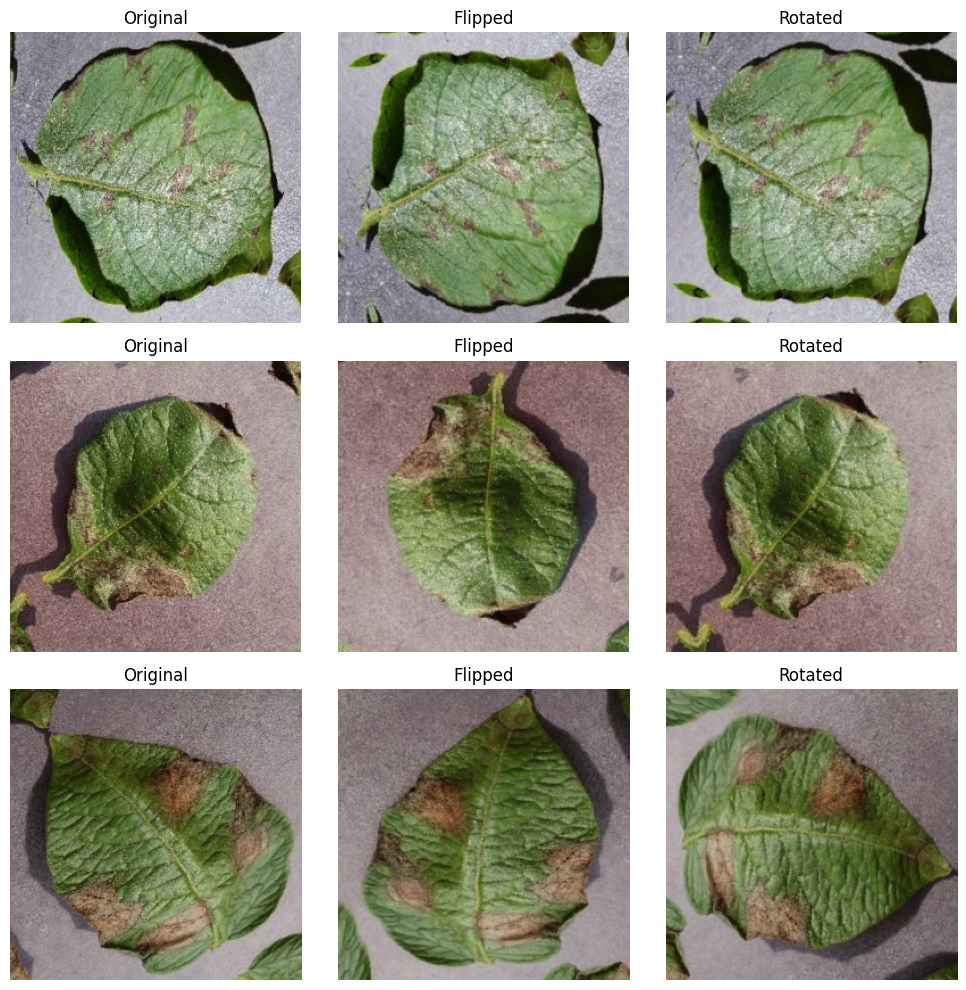

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# Data preprocessing and augmentation
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])
# Applying the augmentation on training data 
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
# Inspecting the Augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        original_image = images[i//3].numpy().astype("uint8")
        augmented_images = data_augmentation(original_image[np.newaxis, ...])
        
        if i % 3 == 0:  # Display original image
            plt.subplot(3, 3, i + 1)
            plt.imshow(original_image)
            plt.title("Original")
            plt.axis("off")
        elif i % 3 == 1:  # Display flipped image
            plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.title("Flipped")
            plt.axis("off")
        else:  # Display rotated image
            plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.title("Rotated")
            plt.axis("off")

plt.tight_layout()
plt.show()

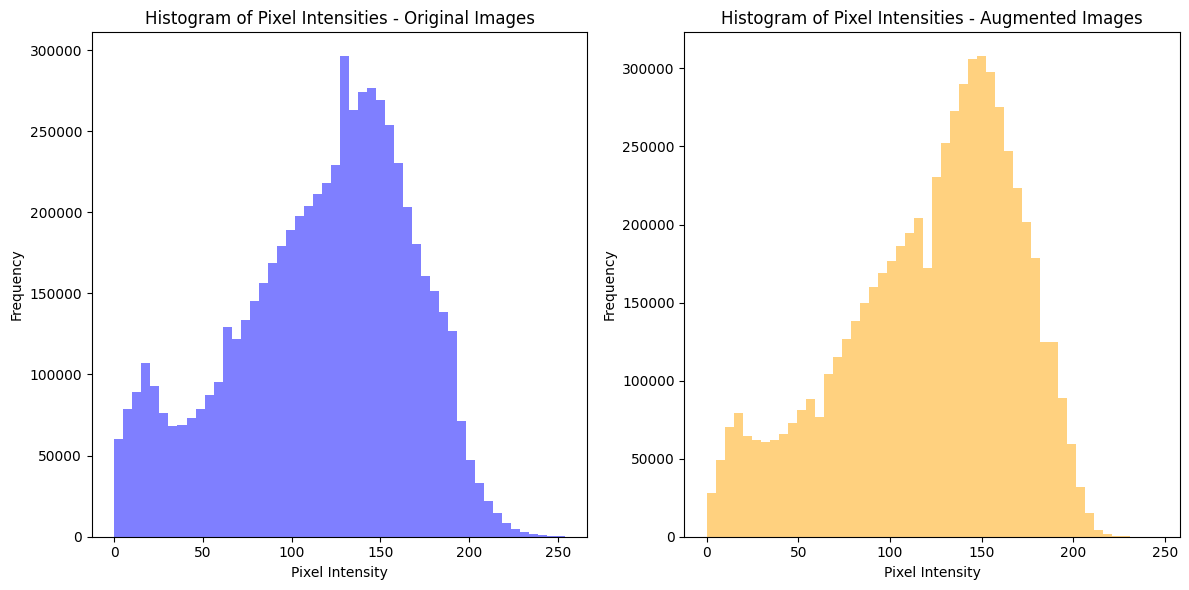

Histogram values for original images:
Histogram values: [6.01230e+04 7.84690e+04 8.91930e+04 1.07208e+05 9.31640e+04 7.62750e+04
 6.84520e+04 6.89050e+04 7.29210e+04 7.87050e+04 8.72890e+04 9.55080e+04
 1.29127e+05 1.21619e+05 1.33874e+05 1.45479e+05 1.56317e+05 1.68422e+05
 1.79342e+05 1.89362e+05 1.97518e+05 2.03869e+05 2.11221e+05 2.18111e+05
 2.29224e+05 2.96090e+05 2.62763e+05 2.74124e+05 2.76856e+05 2.69415e+05
 2.54082e+05 2.30323e+05 2.03011e+05 1.80318e+05 1.60644e+05 1.51566e+05
 1.38241e+05 1.26528e+05 7.12610e+04 4.74800e+04 3.31320e+04 2.22740e+04
 1.43290e+04 8.63600e+03 4.79900e+03 2.75400e+03 1.59000e+03 9.30000e+02
 4.09000e+02 2.04000e+02]
Bin edges: [  0.     5.08  10.16  15.24  20.32  25.4   30.48  35.56  40.64  45.72
  50.8   55.88  60.96  66.04  71.12  76.2   81.28  86.36  91.44  96.52
 101.6  106.68 111.76 116.84 121.92 127.   132.08 137.16 142.24 147.32
 152.4  157.48 162.56 167.64 172.72 177.8  182.88 187.96 193.04 198.12
 203.2  208.28 213.36 218.44 223.52 228

In [4]:
# Histograms of pixel intensities
plt.figure(figsize=(12, 6))

# Histograms for original images
plt.subplot(1, 2, 1)
plt.title('Histogram of Pixel Intensities - Original Images')
for images, _ in train_ds.take(1):
    original_image = images.numpy().astype("uint8")
    hist_values, bins, _ = plt.hist(original_image.flatten(), bins=50, color='blue', alpha=0.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Histograms for augmented images
plt.subplot(1, 2, 2)
plt.title('Histogram of Pixel Intensities - Augmented Images')
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images, training=True).numpy().astype("uint8")
    hist_values_augmented, bins_augmented, _ = plt.hist(augmented_images.flatten(), bins=50, color='orange', alpha=0.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histogram values
print("Histogram values for original images:")
print("Histogram values:", hist_values)
print("Bin edges:", bins)

print("\nHistogram values for augmented images:")
print("Histogram values:", hist_values_augmented)
print("Bin edges:", bins_augmented)

# Cell 4: Defining and Training Models

Training EfficientNet...
Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 977ms/step - accuracy: 0.4357 - loss: 0.9933 - val_accuracy: 0.0952 - val_loss: 1.1827
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 936ms/step - accuracy: 0.4704 - loss: 0.9103 - val_accuracy: 0.4635 - val_loss: 1.0239
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 891ms/step - accuracy: 0.4424 - loss: 0.9099 - val_accuracy: 0.4948 - val_loss: 0.9742
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.4506 - loss: 0.9169 - val_accuracy: 0.4740 - val_loss: 0.9225
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 907ms/step - accuracy: 0.4668 - loss: 0.8943 - val_accuracy: 0.4271 - val_loss: 0.9473
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 900ms/step - accuracy: 0.4850 - loss: 0.9206 - val_accuracy: 0.4479 - val_loss: 0.9476
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.4595 - loss: 0.9027 - val_accuracy: 0.4479 - val_loss: 0.8848
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 951ms/step - accuracy: 0.4473 

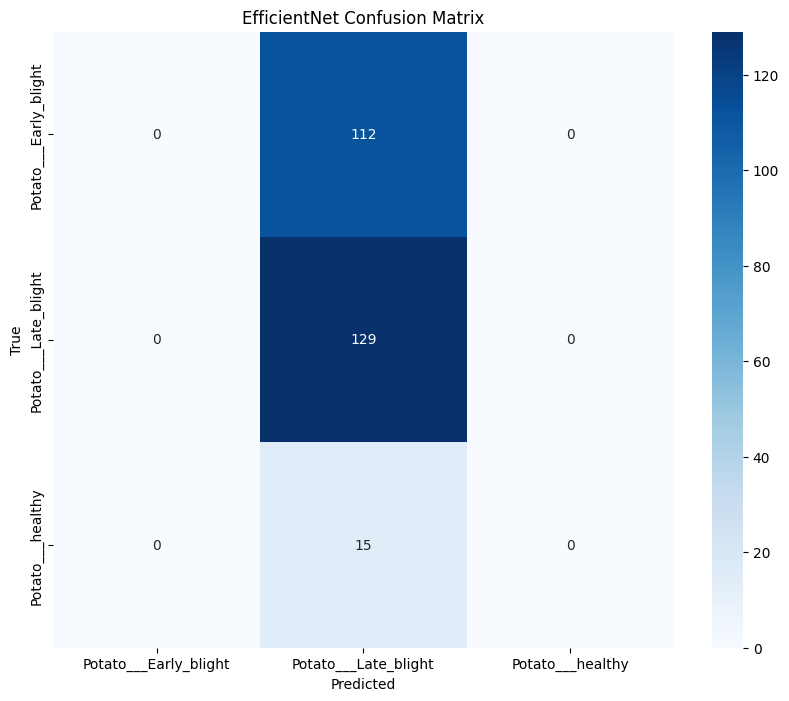

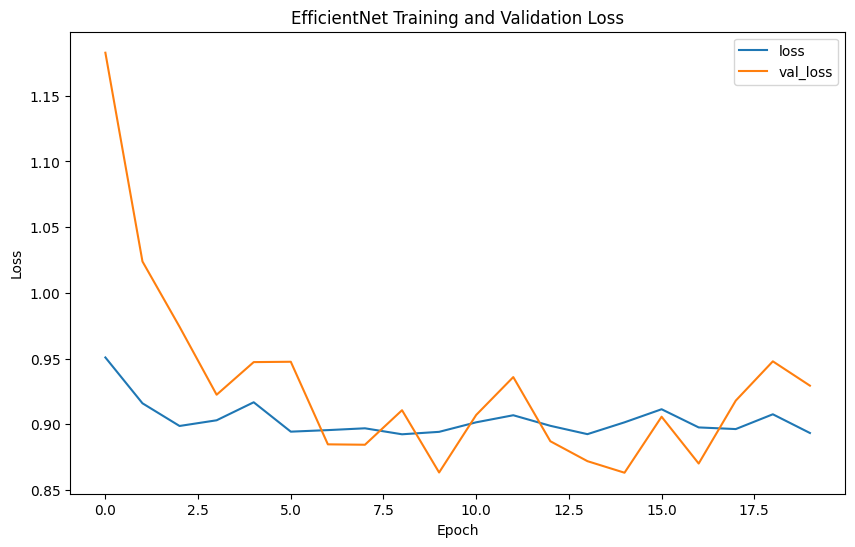

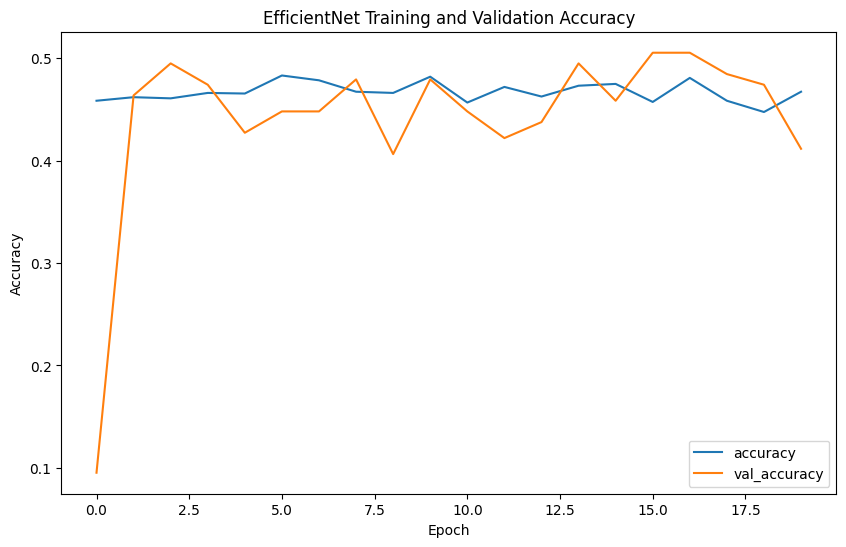

Precision for EfficientNet: 0.2539215087890625
Recall for EfficientNet: 0.50390625
F1-score for EfficientNet: 0.33768262987012987


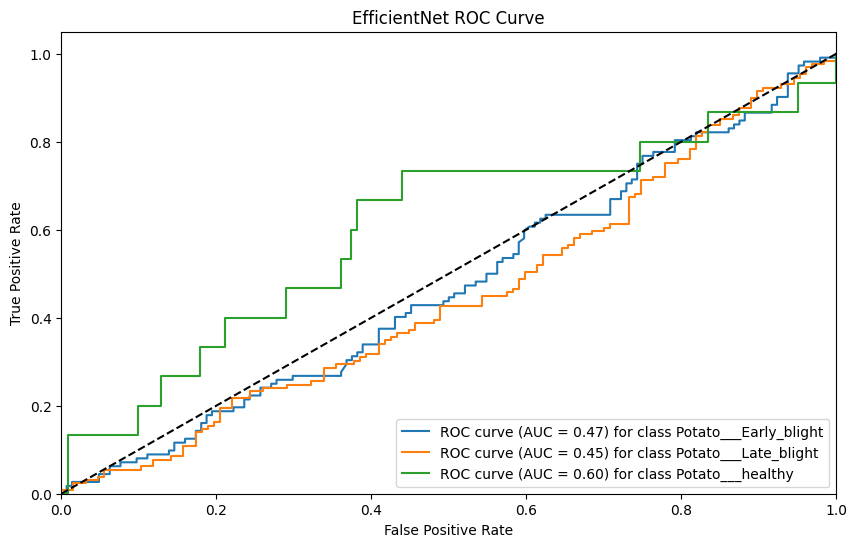

Accuracy for EfficientNet: 0.46484375
Training VGG...
Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.4463 - loss: 1.1326 - val_accuracy: 0.8229 - val_loss: 0.4919
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 403s 8s/step - accuracy: 0.7997 - loss: 0.5251 - val_accuracy: 0.8646 - val_loss: 0.4166
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 437s 8s/step - accuracy: 0.8897 - loss: 0.3054 - val_accuracy: 0.8542 - val_loss: 0.3305
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 433s 8s/step - accuracy: 0.9057 - loss: 0.2172 - val_accuracy: 0.9531 - val_loss: 0.1674
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 410s 8s/step - accuracy: 0.9294 - loss: 0.1838 - val_accuracy: 0.9821 - val_loss: 0.0859
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.9518 - loss: 0.1347 - val_accuracy: 0.9375 - val_loss: 0.1534
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - accuracy: 0.9543 - loss: 0.1365 - val_accuracy: 0.9896 - val_loss: 0.0476
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - accu

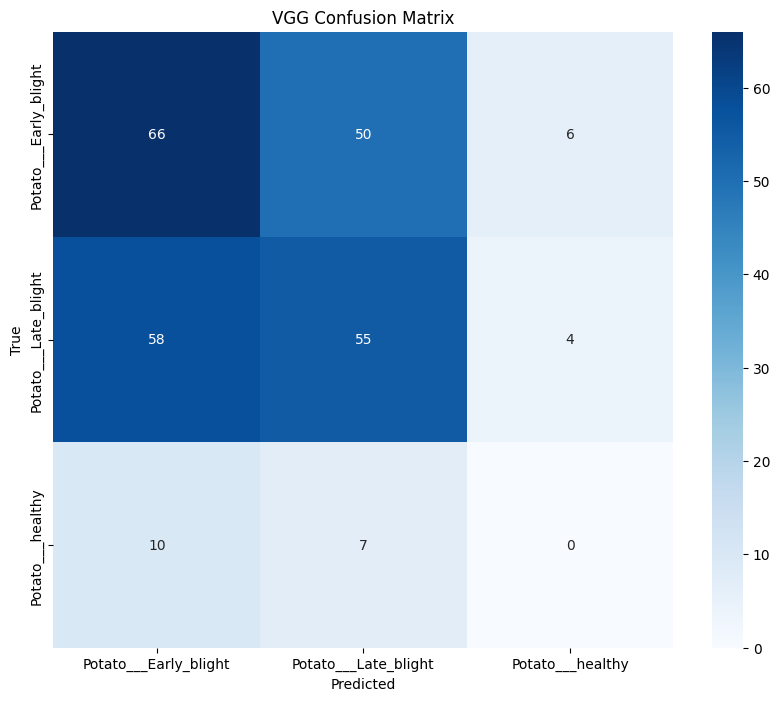

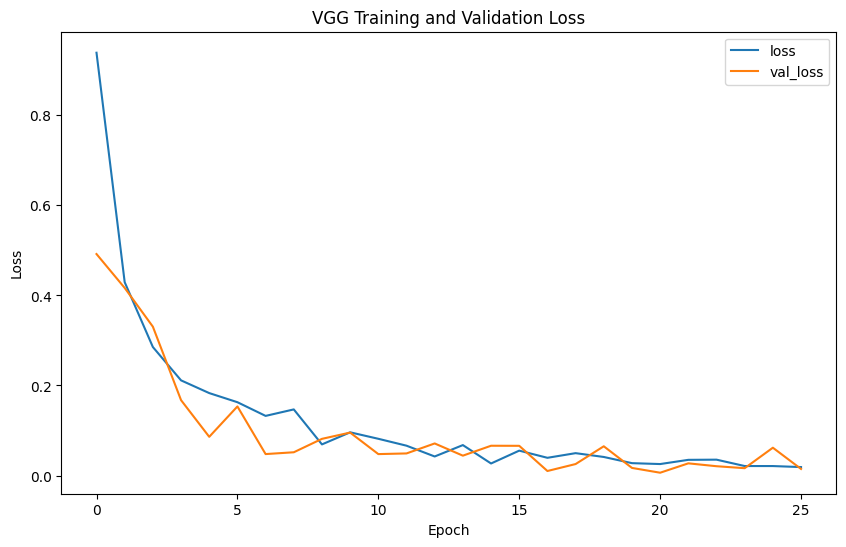

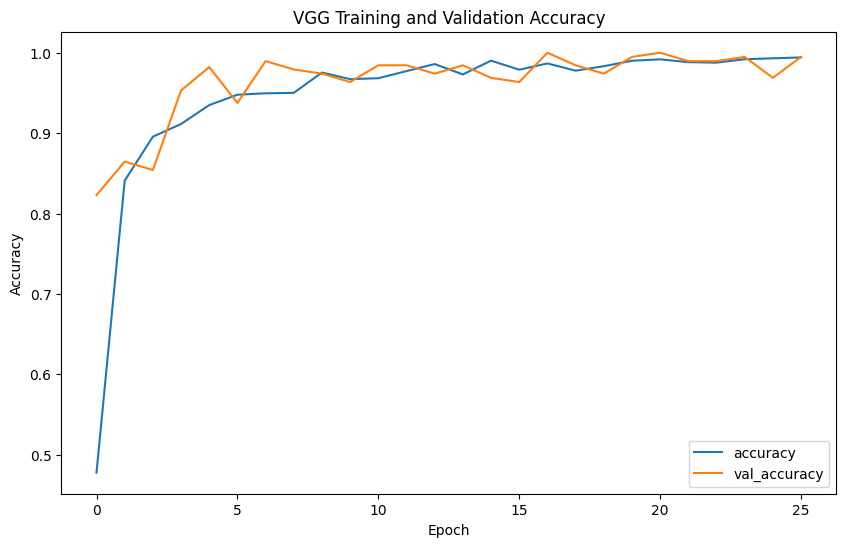

Precision for VGG: 0.4591598022721215
Recall for VGG: 0.47265625
F1-score for VGG: 0.46526220063455237


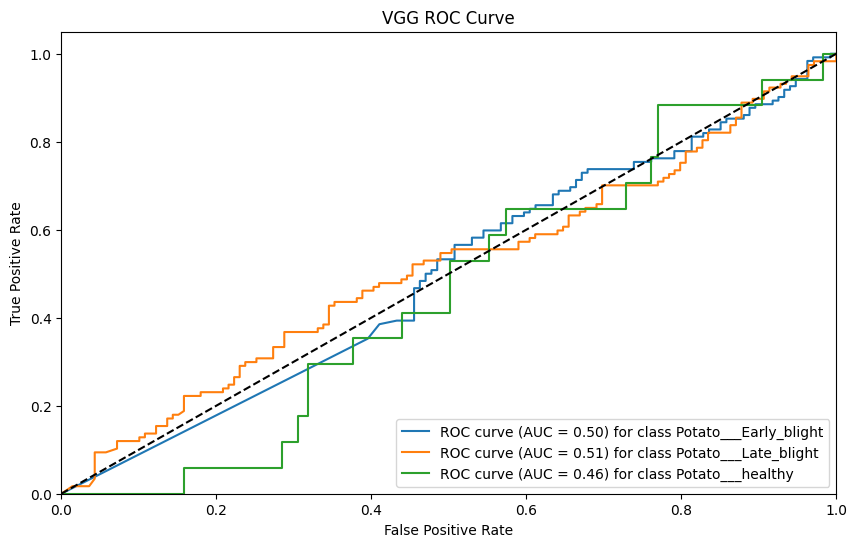

Accuracy for VGG: 0.9956896305084229
Training ResNet...
Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.6647 - loss: 0.8058 - val_accuracy: 0.5000 - val_loss: 2.6280
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.7901 - loss: 0.5162 - val_accuracy: 0.4948 - val_loss: 1.3070
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.8130 - loss: 0.4851 - val_accuracy: 0.8095 - val_loss: 0.5442
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7968 - loss: 0.5512 - val_accuracy: 0.5677 - val_loss: 0.9937
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8292 - loss: 0.4612 - val_accuracy: 0.5714 - val_loss: 1.2349
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8203 - loss: 0.4828 - val_accuracy: 0.6510 - val_loss: 0.8031
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7875 - loss: 0.5498 - val_accuracy: 0.7619 - val_loss: 0.6260
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - ac

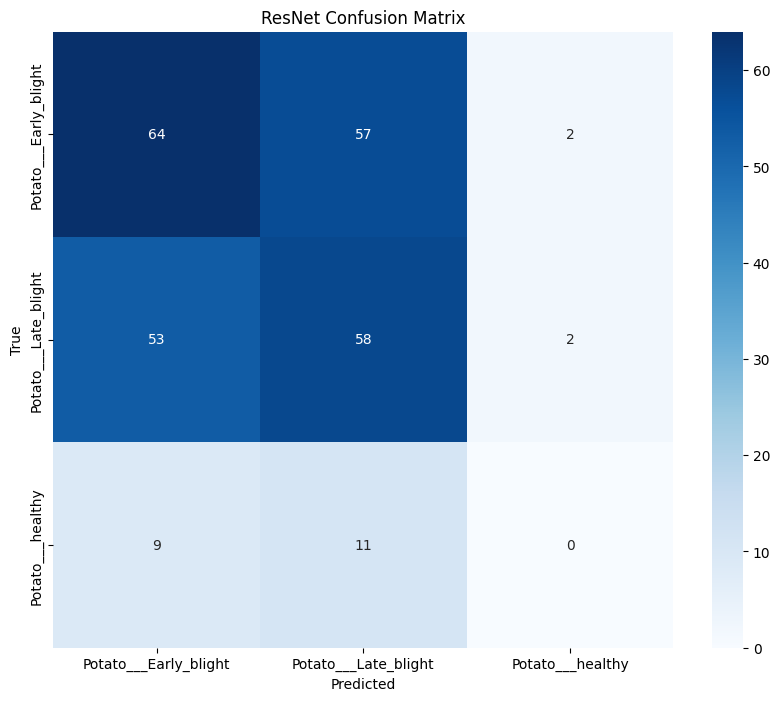

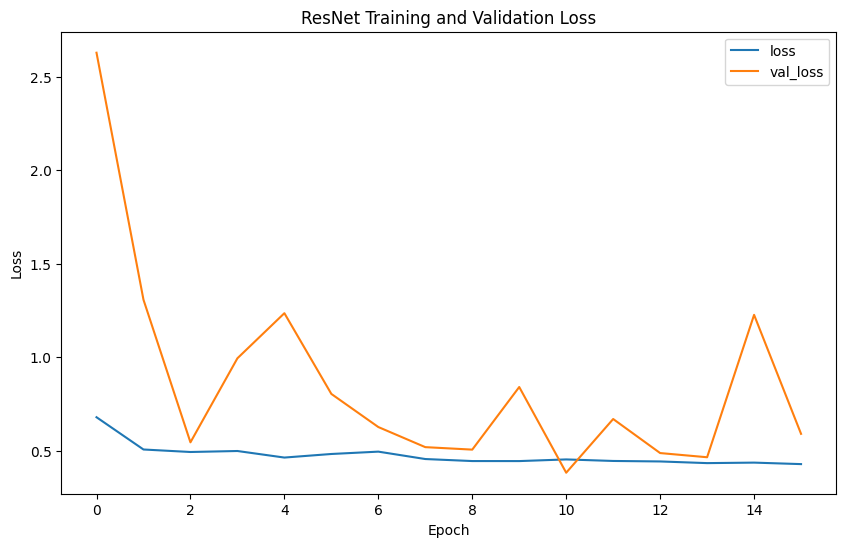

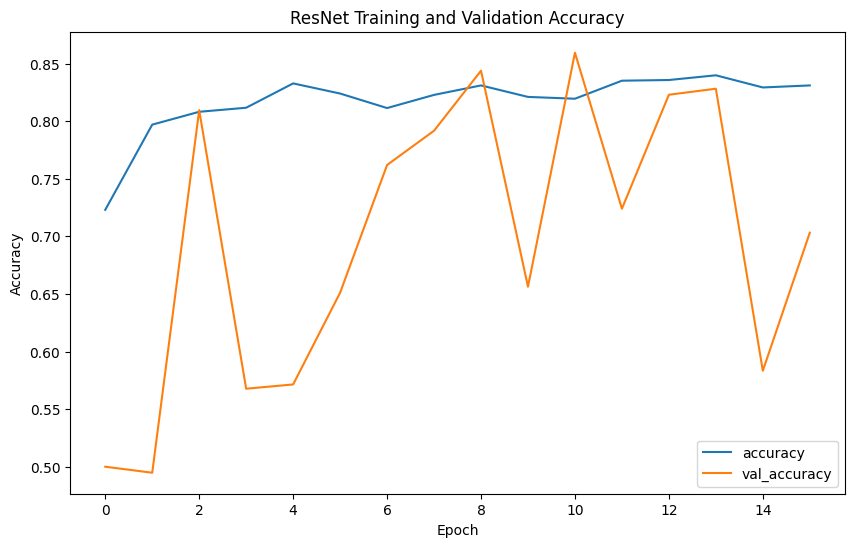

Precision for ResNet: 0.447234623015873
Recall for ResNet: 0.4765625
F1-score for ResNet: 0.46122696854363054


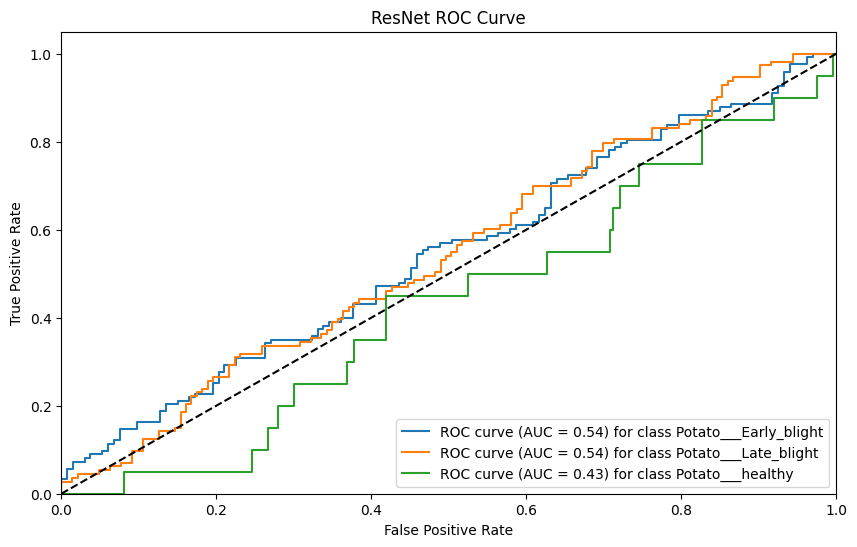

Accuracy for ResNet: 0.84765625
Training Inception...
Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6412 - loss: 0.8522 - val_accuracy: 0.9167 - val_loss: 0.2478
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8898 - loss: 0.3041 - val_accuracy: 0.8854 - val_loss: 0.2597
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9101 - loss: 0.2381 - val_accuracy: 0.9635 - val_loss: 0.1367
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9390 - loss: 0.1816 - val_accuracy: 0.9115 - val_loss: 0.2174
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9339 - loss: 0.1811 - val_accuracy: 0.9115 - val_loss: 0.2293
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9418 - loss: 0.1760 - val_accuracy: 0.9531 - val_loss: 0.1557
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9456 - loss: 0.1557 - val_accuracy: 0.9740 - val_loss: 0.1326
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy

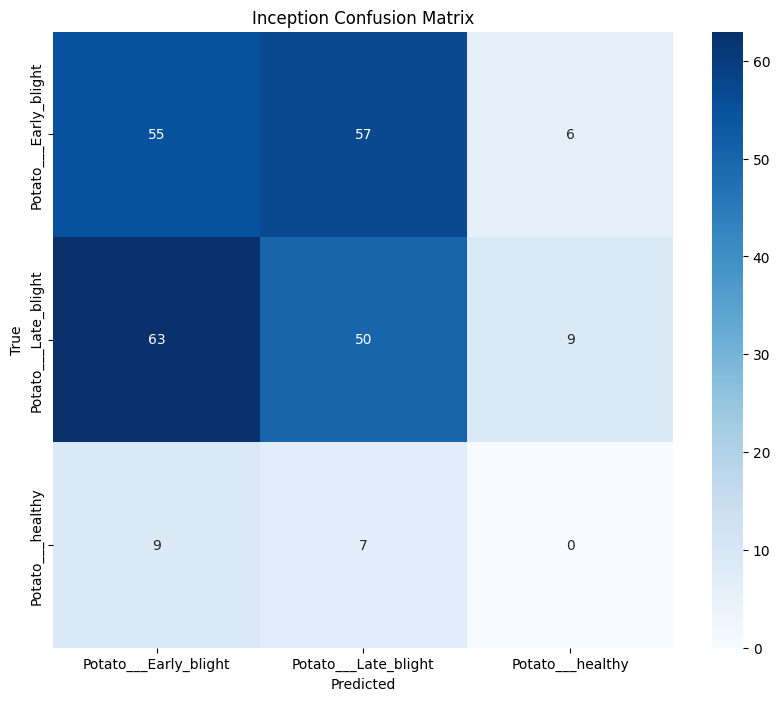

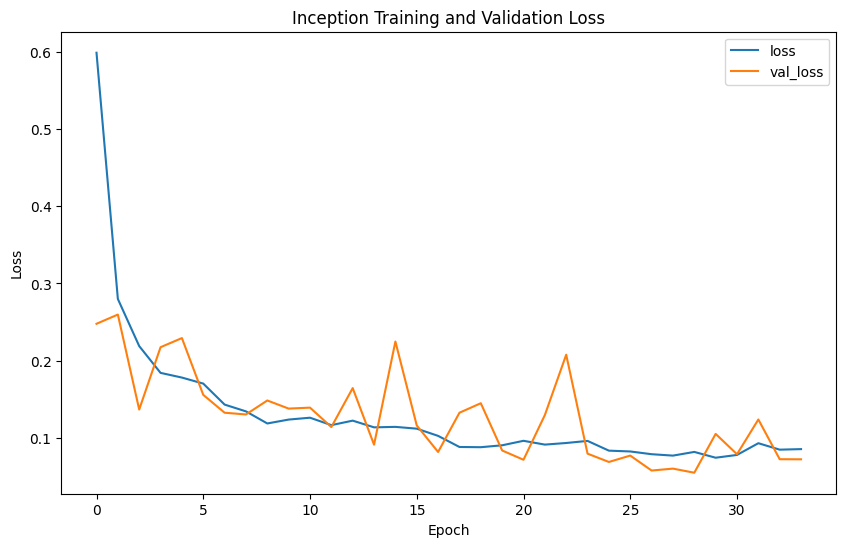

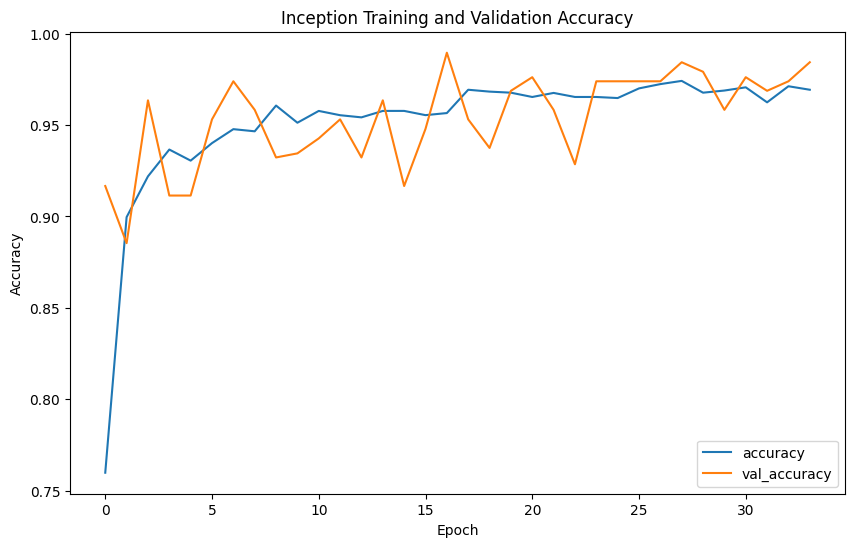

Precision for Inception: 0.4086372427130819
Recall for Inception: 0.41015625
F1-score for Inception: 0.4088847933241093


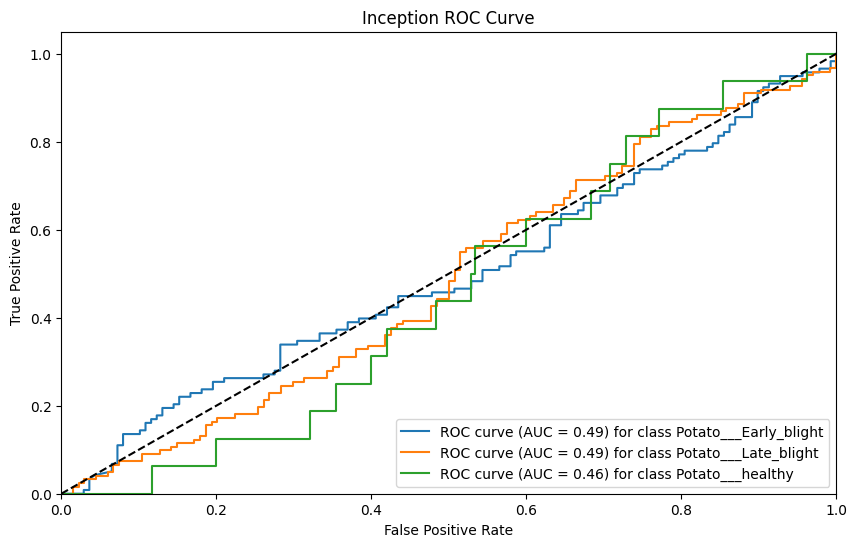

Accuracy for Inception: 0.98046875
Training DenseNet...
Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.7541 - loss: 0.5722 - val_accuracy: 0.9219 - val_loss: 0.1955
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9510 - loss: 0.1435 - val_accuracy: 0.9740 - val_loss: 0.1011
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9396 - loss: 0.1644 - val_accuracy: 0.9844 - val_loss: 0.0640
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9666 - loss: 0.0958 - val_accuracy: 1.0000 - val_loss: 0.0348
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9746 - loss: 0.0731 - val_accuracy: 0.9479 - val_loss: 0.1409
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9429 - loss: 0.1481 - val_accuracy: 0.9792 - val_loss: 0.0480
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9672 - loss: 0.1292 - val_accuracy: 0.9844 - val_loss: 0.0390
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - ac

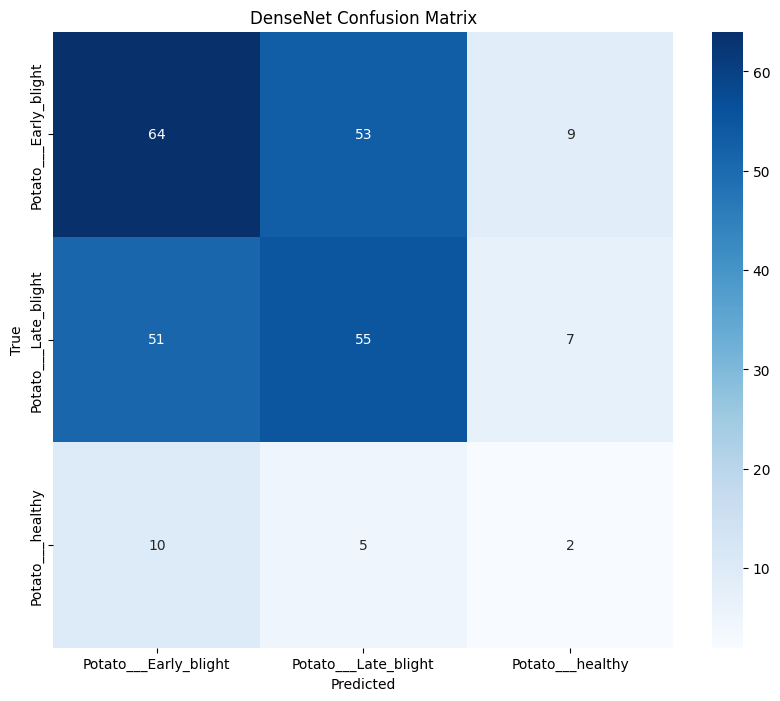

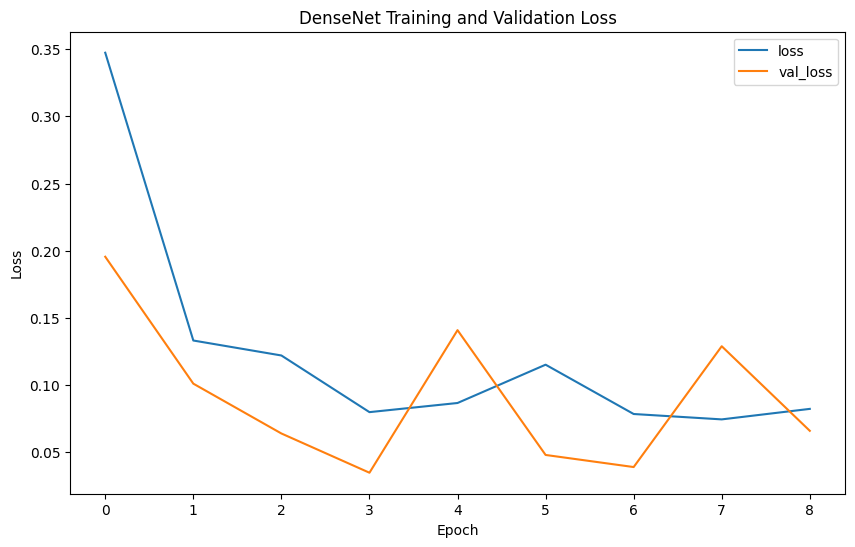

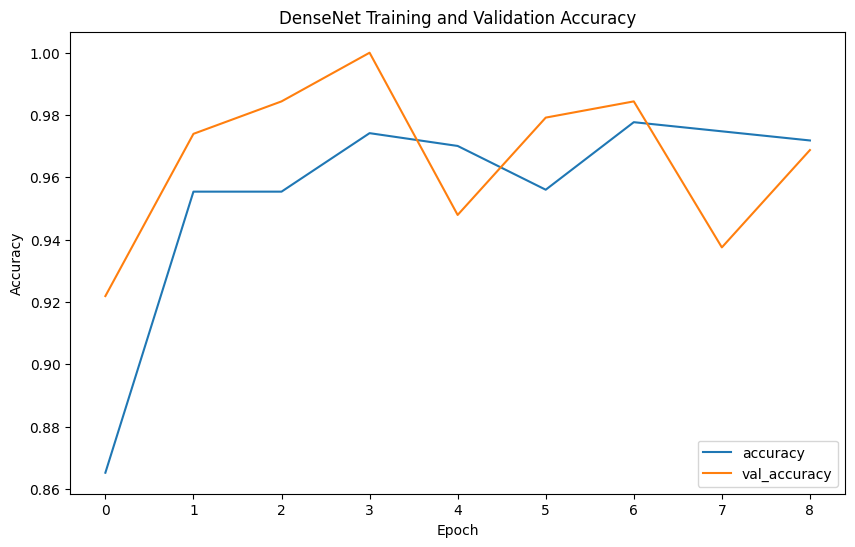

Precision for DenseNet: 0.4742222222222222
Recall for DenseNet: 0.47265625
F1-score for DenseNet: 0.47342905165054067


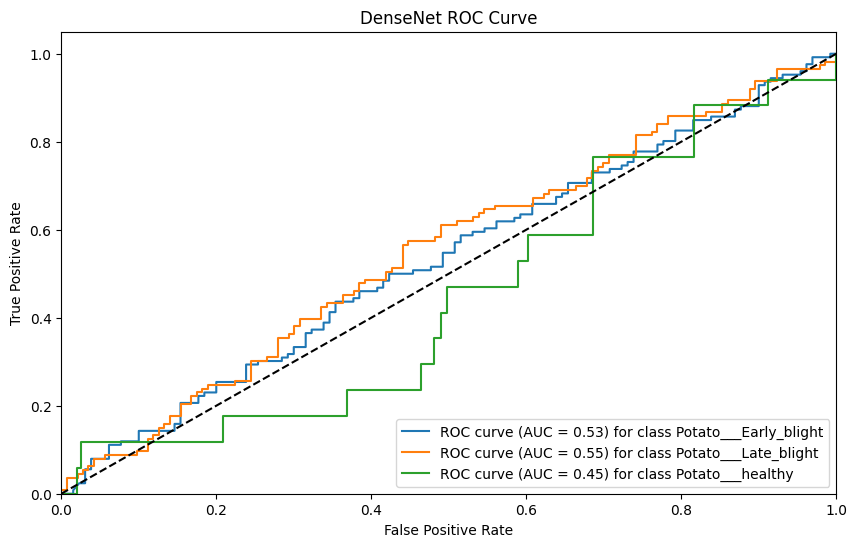

Accuracy for DenseNet: 0.98828125
Best Model: VGG, Accuracy: 0.9956896305084229


In [6]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Defining CNN models with fine-tuning
def build_fine_tuned_model(model_name):
    if model_name == 'VGG':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    elif model_name == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    elif model_name == 'Inception':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    elif model_name == 'DenseNet':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    elif model_name == 'EfficientNet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    else:
        raise ValueError("Invalid model name")
    
    # Freezing all layers except the last one
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    
    model = models.Sequential([
        resize_and_rescale,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

# Train, fine-tune, evaluating models
models_to_train = ['EfficientNet', 'VGG', 'ResNet', 'Inception', 'DenseNet']
best_model = None
best_accuracy = 0.0

for model_name in models_to_train:
    print(f"Training {model_name}...")
    model = build_fine_tuned_model(model_name)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        callbacks=[early_stopping],
        verbose=1,
        epochs=EPOCHS
    )
    
    # Evaluation metrics
    scores = model.evaluate(test_ds)
    y_pred = model.predict(test_ds)
    y_true = tf.concat([y for x, y in test_ds], axis=0)
    class_labels = [i for i in range(len(class_names))]
    class_names_str = [str(i) for i in class_names]
    
    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, tf.argmax(y_pred, axis=1), target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, tf.argmax(y_pred, axis=1), labels=class_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.show()
    
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.show()
    
    # Precision, Recall, and F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, tf.argmax(y_pred, axis=1), average='weighted')
    print(f"Precision for {model_name}: {precision}")
    print(f"Recall for {model_name}: {recall}")
    print(f"F1-score for {model_name}: {f1_score}")
    
    # ROC Curve and AUC Score
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve((y_true == i), y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {roc_auc[i]:0.2f}) for class {class_names_str[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print and check all values and print which is the best model out of all and its results
    print(f"Accuracy for {model_name}: {scores[1]}")
    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model
        best_model_name = model_name

print(f"Best Model: {best_model_name}, Accuracy: {best_accuracy}")


First image to predict:


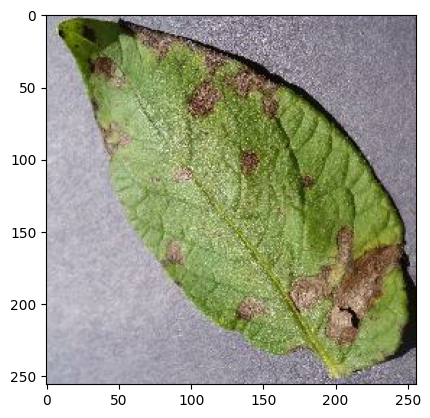

Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: Potato___Early_blight
Accuracy: 100.00%


In [7]:
import numpy as np

# Get a batch of images and labels from the test dataset
for images_batch, labels_batch in test_ds.take(1):
    
    # Extract the first image and its corresponding label
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    # Display the first image and its actual label
    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    print("Actual label:", class_names[first_label])
    
    # Make predictions using the best model
    batch_prediction = best_model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    
    # Display the predicted label and accuracy percentage
    print("Predicted label:", class_names[predicted_label])
    
    # Calculate accuracy percentage
    accuracy_percentage = batch_prediction[0][predicted_label] * 100
    print("Accuracy:", f"{accuracy_percentage:.2f}%")


In [ ]:
2+2